# SNAX (SuperNova Analysis in XENON)

This notebook describes the main usage of the `snax` package. <br>

> Last updated: ~26/07/2023~ 18.03.2024 <br>

The code is modular so that it can be integrated into different studies smoothly. <br>

Main concept is that there are ~5 main ingredients. <br>
 - `snax.SnewpyWrapper.SnewpyModel` wrapper around the core collapse supernova simulation collection from the snewpy package
 - `snax.models.SnaxModel` defines the _snax models_, it has some attributes on top of the SnewpyModel like interaction rates.
 - `snax.Nucleus` creates a Xenon atom, pure or isotope, computes cross sections
 - `snax.interactions` accepts a model, and creates a nuclei to handle the interactions.
 - `snax.Simulations` deals with the instruction generation and simulations

Notice that this is a tutorial, and I'll go through each modular aspects but for practical purposes, many of them can be bypassed and it is handled in the backgorund.

In [1]:
from xenonnt_plot_style import XENONPlotStyle as xps
xps.use('xenonnt')

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import astropy.units as u
from snewpy.neutrino import Flavor

from snax.SnewpyWrapper import SnewpyModel
from snax.models import SnaxModel
from snax.interactions import Interactions
from snax.Simulations import SimulationInstructions, SimulateSignal

## Models
Let's have a look at the Supernova Models. SNAX has a wrapper around snewpy for easier handling of the different supernova physics models.

In [24]:
# supernova model from snewpy
loader = SnewpyModel() # if the snewpy models are loaded in a different path, this can be passed to the class
parameter_combinations_df = loader.display_models("Nakazato_2013", verbose=False)

  0%|          | 0/24 [00:00<?, ?it/s]

For a given base model (e.g. "Nakazato_2013") there may be several combinations. Each of them are also indexed for easier calling, and each have a unique hash. Notice that the combinations that do not _exist_ are already removed.

In [4]:
parameter_combinations_df.head(3)

,progenitor_mass,revival_time,metallicity,eos,hash
Combination Index,,,,,
1,13.0 solMass,100.0 ms,0.020,shen,kbt3fazggw
2,13.0 solMass,100.0 ms,0.004,shen,5asgkxbxly
3,13.0 solMass,200.0 ms,0.020,shen,d6g2sqpgyk


If nothing is passed by default, it displays the base classes.

In [5]:
loader.display_models()

dict_keys(['Bollig_2016', 'Fornax_2019', 'Fornax_2021', 'Kuroda_2020', 'Nakazato_2013', 'OConnor_2013', 'OConnor_2015', 'PISN', 'Sukhbold_2015', 'Tamborra_2014', 'Type_Ia', 'Walk_2018', 'Walk_2019', 'Warren_2020', 'Zha_2021', 'presn-models'])


Now let's load a snewpy model and look at some model attributes.

In [6]:
nakazato_snax = loader.get_model("Nakazato_2013", combination_index=8)
nakazato_snax

**Nakazato_2013 Model**: nakazato-shen-z0.004-t_rev100ms-s20.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $20$ $\mathrm{M_{\odot}}$|
|EOS | shen |
|Metallicity | 0.004 |
|Revival time | $100$ $\mathrm{ms}$|

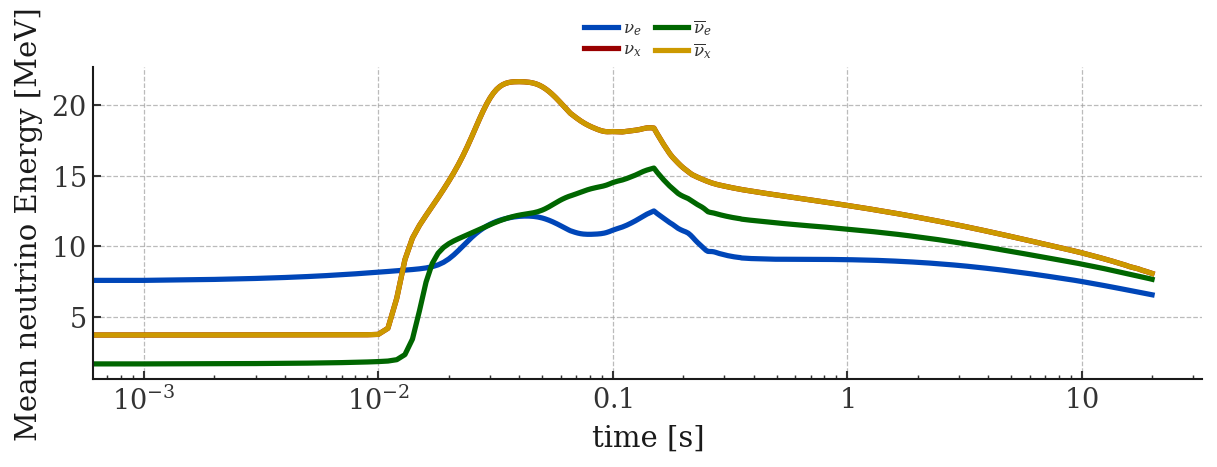

In [7]:
plt.figure(figsize=(8,3))
[plt.semilogx(nakazato_snax.time, nakazato_snax.meanE[f], label=f.to_tex()) for f in Flavor];
plt.ylabel("Mean neutrino Energy [MeV]"); plt.xlabel("time [s]")
plt.legend();

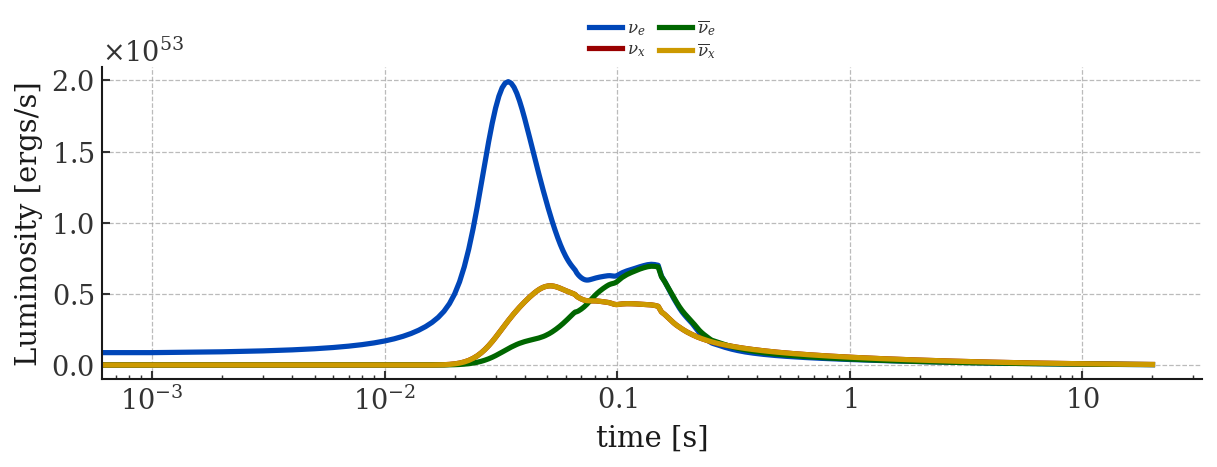

In [8]:
plt.figure(figsize=(8,3))
[plt.semilogx(nakazato_snax.time, nakazato_snax.luminosity[f], label=f.to_tex()) for f in Flavor];
plt.ylabel("Luminosity [ergs/s]"); plt.xlabel("time [s]")
plt.legend();

## Snax Model

The snax model is a smart object where the filename is generated based on the input parameters and is stored locally for easier access. The computed fluxes are also stored, and the next time it tries to compute, it first checks if they are already computed and stored.

In [9]:
# snax model with fluxes computed
sm = SnaxModel(nakazato_snax)
sm.compute_model_fluxes()

>>>>> sn_Nakazato_2013_66vkgeymxq.pkl
> Retrieving object self.proc_locsn_Nakazato_2013_66vkgeymxq.pkl
Fluxes already exist in `self.fluxes`, and force=False, doing nothing.


In [10]:
sm

**Nakazato_2013 Model**: nakazato-shen-z0.004-t_rev100ms-s20.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $20$ $\mathrm{M_{\odot}}$|
|EOS | shen |
|Metallicity | 0.004 |
|Revival time | $100$ $\mathrm{ms}$|
|file name| sn_Nakazato_2013_66vkgeymxq.pkl
|duration | 20.05 s|
|time range| (-0.05 s, 20.0 s)

## Target

In [11]:
from snax.Nucleus import Target
from snax.Xenon_Atom import ATOM_TABLE

print("Target we load", ATOM_TABLE['Xe131'])
singleXe = Target(ATOM_TABLE['Xe131'], pure=True) # pure means setting the abundance to =1 
singleXe

Target we load {'Type': 'Xe131', 'MassNum': 131, 'AtomicNum': 54, 'Mass': 130.90508406, 'Spin': 1.5, 'Fraction': 0.212324}


### The Target<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Values</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>Type</th>
      <td>Xe131</td>
    </tr>
    <tr>
      <th>MassNum</th>
      <td>131</td>
    </tr>
    <tr>
      <th>AtomicNum</th>
      <td>54</td>
    </tr>
    <tr>
      <th>Mass</th>
      <td>130.905084</td>
    </tr>
    <tr>
      <th>Spin</th>
      <td>1.5</td>
    </tr>
    <tr>
      <th>Fraction</th>
      <td>0.212324</td>
    </tr>
  </tbody>
</table>
</div><br>


In [14]:
recoil_en = np.linspace(0,30,100) * u.keV
neutrino_en = sm.neutrino_energies

formfac = singleXe.form_factor(np.linspace(0,150,100) * u.keV)
crosssec = singleXe.nN_cross_section(neutrino_en, recoil_en)

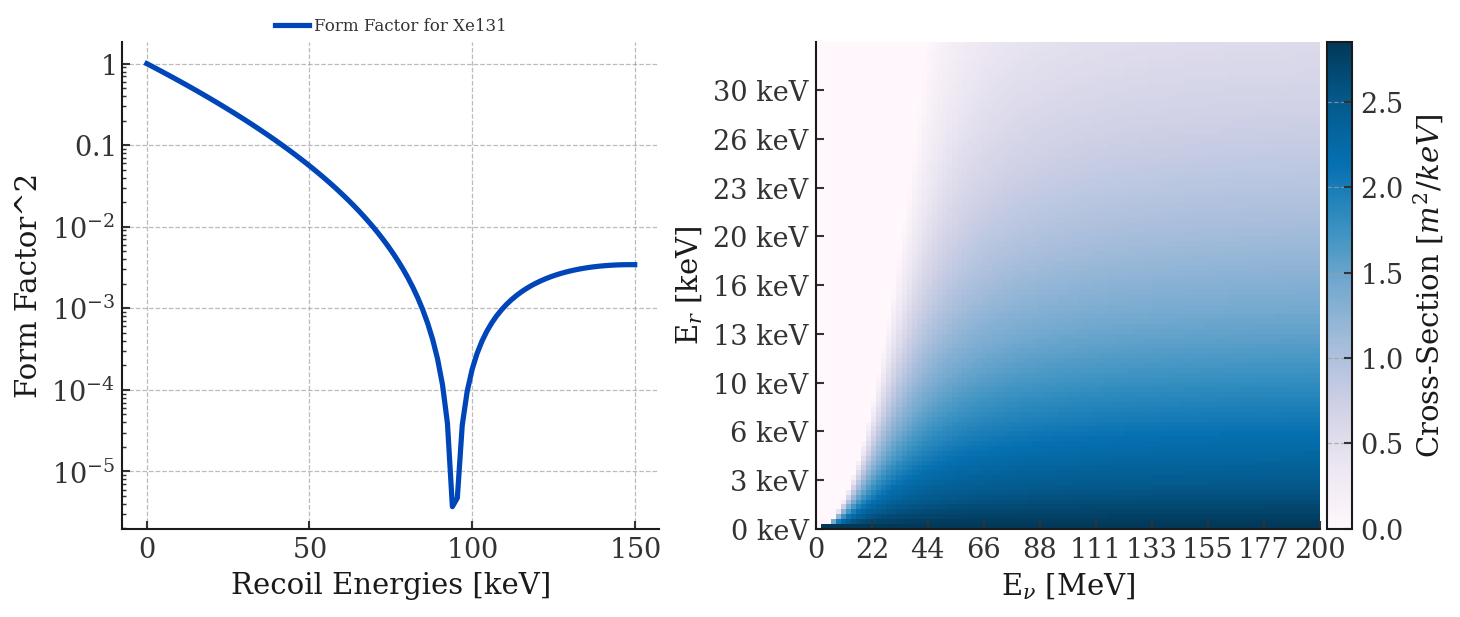

In [29]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(9,4))
ax1.semilogy(np.linspace(0,150,100) * u.keV, formfac**2, label='Form Factor for Xe131');
ax1.set_xlabel(f'Recoil Energies [{recoil_en.unit}]')
ax1.set_ylabel('Form Factor^2')
ax1.legend();

ax2.grid(False)
im = ax2.pcolormesh((crosssec * 1e43).value, cmap='PuBu') #, norm=LogNorm())
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
cb = fig.colorbar(im, cax=cax, orientation='vertical')
cb.set_label(r"Cross-Section [$m^2/keV$]")
ax2.set_xlabel(r'E$_\nu$ [MeV]',) # fontsize=16)
ax2.set_ylabel(r'E$_r$ [keV]',) # fontsize=16)
ax2.set_xticks(ticks=np.linspace(0, crosssec.shape[1], 10), labels=np.linspace(neutrino_en[0], neutrino_en[-1], 10, dtype=int).value)
ax2.set_yticks(ticks=np.arange(0, crosssec.shape[0], 10), labels=np.linspace(recoil_en[0], recoil_en[-1], 10, dtype=int));

## Interactions

In [6]:
# interactions with the xenon target
interaction = Interactions(sm, Nuclei="Xenon", isotope="mix") # uses the snax.Nucleus in the background 
interaction.compute_interaction_rates()
interaction.scale_rates(distance=10, volume=5.9);

> Retrieving object self.proc_loc/sn_Nakazato_2013_66vkgeymxq_interaction_Xenon_mix.pkl


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

> Computed the total rates at the source for 1 atom (not scaled)


Notice that the interaction object file is also created and stored locally. Removing the neccessity to compute it each time.

In [7]:
interaction

**Nakazato_2013 Model**: nakazato-shen-z0.004-t_rev100ms-s20.0.fits

|Parameter|Value|
|:--------|:----:|
|Progenitor mass | $20$ $\mathrm{M_{\odot}}$|
|EOS | shen |
|Metallicity | 0.004 |
|Revival time | $100$ $\mathrm{ms}$|
|file name| sn_Nakazato_2013_66vkgeymxq.pkl
|duration | 20.05 s|
|time range| (-0.05 s, 20.0 s)
|Interaction file| sn_Nakazato_2013_66vkgeymxq_interaction_Xenon_mix.pkl
|Target | mix Xenon
|Computed, scaled | True, True
|distance | 10.0 kpc
|volume | 5.9 t
|Expected Total | 102 ct

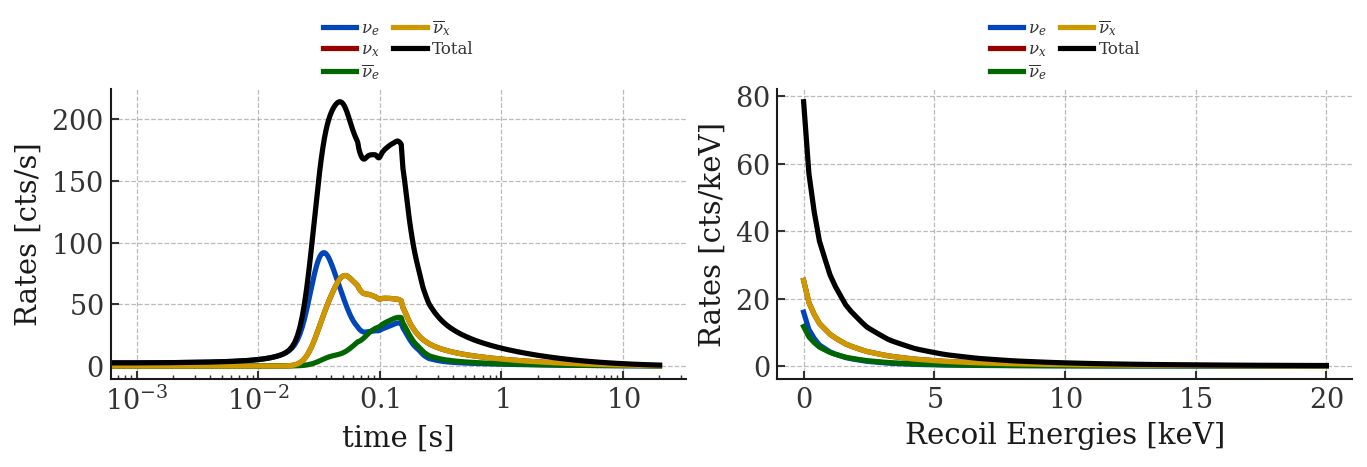

In [12]:
fig, axes = plt.subplots(ncols=2, figsize=(9,3))
[axes[0].semilogx(interaction.times, interaction.rates_per_time_scaled[f], label=f.to_tex()) for f in Flavor];
[axes[1].plot(interaction.recoil_energies, interaction.rates_per_recoil_scaled[f], label=f.to_tex()) for f in Flavor];
axes[0].semilogx(interaction.times, interaction.rates_per_time_scaled["Total"], label="Total", color='k')
axes[1].plot(interaction.recoil_energies, interaction.rates_per_recoil_scaled["Total"], label="Total", color='k')
axes[0].set_ylabel("Rates [cts/s]"); axes[1].set_ylabel("Rates [cts/keV]"); 
axes[0].set_xlabel("time [s]"); axes[1].set_xlabel("Recoil Energies [keV]")
axes[0].legend(); axes[1].legend();

After computing the interactions. We can start creating simulation instructions and simulations at different levels.

## Simulations

Simulator can generate instructions for wfsim, fuse detector physics or fuse microphysics. By default, it uses fuse microphysics. 

In [7]:
# all the information is in the "interaction" object
simulator = SimulateSignal(interaction, instruction_type="fuse_microphysics")

In [9]:
instructions_detphys = simulator.generate_fuse_detectorphysics_instructions()
instructions_micorphys = simulator.generate_fuse_microphysics_instructions()

> Using default local field map.: 
> fieldmap_2D_B2d75n_C2d75n_G0d3p_A4d9p_T0d9n_PMTs1d3n_FSR0d65p_QPTFE_0d5n_0d4p.json.gz


/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.9/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in _quanta_from_NEST (vectorized)
  outputs = ufunc(*inputs)


In [25]:
instructions_detphys.head(2)

,x,y,z,ed,t,e_field,photons,electrons,excitons,nestid,eventid
0,-50.944557,-5.444869,-42.158369,8.836640,22330334,22.692980,61,47,50,0,0
1,-14.335366,9.713381,-96.411532,0.561005,31349157,22.176836,2,2,2,0,1


In [16]:
instructions_micorphys.head(2)

,eventid,xp,yp,zp,xp_pri,yp_pri,zp_pri,ed,time,type,trackid,parentid,creaproc,parenttype,edproc
0,0,49.678968,-356.383909,-906.621975,49.678968,-356.383909,-906.621975,0.566613,84521725,neutron,0.0,0,None,None,None
1,1,297.564385,-358.206063,-1204.829136,297.564385,-358.206063,-1204.829136,1.617241,100120640,neutron,0.0,0,None,None,None


We can either pass these instructions, or directly simulate something in which case the instructions are generated in the background. Notice that you do not need to specify a run number as it finds an appropriate run number and returns it.

In [30]:
st, run_number = simulator.simulate_single()

You can figure out the simulated supernova model based on the hash.

In [10]:
simulator.what_is_hash_for("mf2arrvz2z")

,name,hash,Combination Index,progenitor_mass,revival_time,metallicity,eos
37,Nakazato_2013,mf2arrvz2z,8,20.0 solMass,100.0 ms,0.004,shen


Build the microphysics and on top you can build all straxen datatypes

In [11]:
mp_summaries = st.get_df(["mf2arrvz2z_00005", "mf2arrvz2z_00006", "mf2arrvz2z_00007"], "microphysics_summary")
peak_basics = st.get_df(["mf2arrvz2z_00005", "mf2arrvz2z_00006", "mf2arrvz2z_00007"], ("peak_basics", "peak_proximity"))

Loading 3 runs:   0%|          | 0/3 [00:00<?, ?it/s]

Source finished!


/opt/XENONnT/anaconda/envs/XENONnT_development/lib/python3.9/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in func (vectorized)
  outputs = ufunc(*inputs)


### multiple simulations in one file

It is some times desired this way, as the individual simulations are always starting at t=0 and spanning similar time ranges. Multiple simulations can be spread out in time, allowing for time related features to be calculated properly.

In [31]:
st, run_number = simulator.simulate_multiple(number_of_supernova=30, time_spacing_in_minutes=3)

In [32]:
df_peaks = st.get_df(run_number, ("peak_basics", "peak_proximity"))

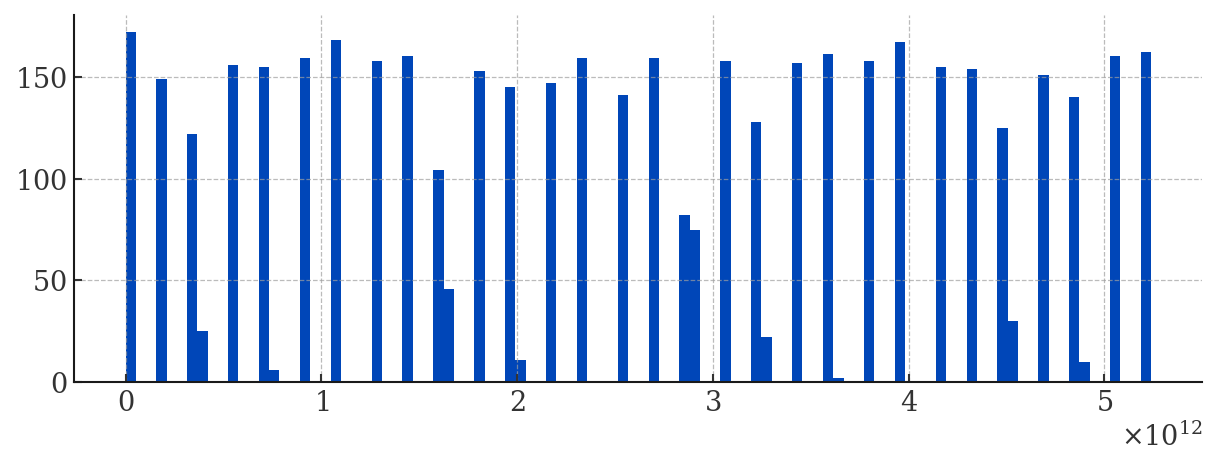

In [10]:
plt.figure(figsize=(8,3))
plt.hist(df_peaks['time'], bins=100);